In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

2025-10-15 22:38:00.540398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Resources** :

*Matrix Factorization techniques for Recommender Systems*, Koren (2009)    
https://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/Koren_Matrix_Factorization.pdf

Hands on Machine Learning with scikit-learn and tensorflow:             
https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

The movieLens dataset:                                                
https://grouplens.org/datasets/movielens/ 

Keras Functional API doc :                                            
https://keras.io/guides/functional_api/


# Recommender systems : collaborative filtering via matrix factorization

Do you wonder how Netflix is able to recommend you movies despite it doesn't know anything about you but the ratings you gave to the movies you watched ? This is what we are going to explore during this 3 days machine learning module.

First off, let's learn about what are recommender system, collaborative filtering and matrix factorization techniques, which are all very well introduced in Koren's 2009 famous article : *Matrix Factorization techniques for Recommender Systems* : https://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/Koren_Matrix_Factorization.pdf . Read the 4 first pages (up to section *adding biases* included). 

Through this notebook we are going to re-implement the model described in the pages you read, and apply it to a classic movie ratings dataset coming from the website *movieLens*. To do so, we will use a powerful deep learning python library called *Keras*, that makes it easy to train complex models based on linear algebra.

## Load the dataset

For this module, we are going to use the movieLens dataset, that contains data from the movie recommending website movielens. The data is a subset of ratings from 0 to 5 given by some users of the website to a subset of movies. You can read more about it here (we are using the latest small dataset) : https://grouplens.org/datasets/movielens/ , and in the *README* file that is in the *data/ml-latest-small/* folder.

Load the ratings data from the `ratings.csv` file into a dataframe. The userId and movieId provided in the file don't start from 0, and are not contiguous (i.e. there are missing indexes).

Re-index the user and movie ids to indexes going from 0 to `nb_users` and 0 to `nb_movies` respectively, by building two dictionnaries `user_ids_map` and `movie_ids_map` that maps the file ids to your new ids. 
And finally, split the rows of this dataframe in a random 90%/10% train/test sets.

To do so, fill the `get_train_test_sets` function below, and respect the returned objects structures that are described in the docstring.


In [2]:
def get_train_test_sets(data_path, train_prop = 0.9):
    """
    Build train and test sets and reindex userIds and MovieIds from 0 with contiguous indexes.
    
    Input: 
        data_path : string : the path to the ratings file
        train_prop : float : The proportion of the training set 
    
    Output:
        train : pandas.DataFrame : A dataframe with columns [userId, movieId, rating, timestamp], where
            the userId and movieId value have been replaced with new ids starting at 0. 
            Contains `train_prop` random entries from the input file.
        test : pandas.DataFrame : Same as `train`, contains the 1 - `train_prop` remaining entries.
        nb_users : int : Number of unique user ids
        nb_movies : int : Number of unique movie ids
        user_ids_map : dict : A mapping of original file userId to a new index starting at 0.
            Keys are int from the original userId column, values are int of the new indexation.
        movie_ids_map : dict : Same as `user_ids_map` for the movieIds.
    """
    
    #TOFILL
    df = pd.read_csv(data_path)

    # calculate the number of users and movies
    nb_users = df.userId.nunique()
    nb_movies = df.movieId.nunique()

    # map the df indices for users and movies to new indices starting at 0
    user_ids_map = dict(zip(df.userId.sort_values().unique().tolist(), 
                            [i for i in range(0,nb_users)]))
    movie_ids_map = dict(zip(df.movieId.sort_values().unique().tolist(), 
                             [i for i in range(0,nb_movies)]))
    
    df['userId'] = df['userId'].map(user_ids_map)
    df['movieId'] = df['movieId'].map(movie_ids_map)

    train, test = train_test_split(df, train_size=train_prop, random_state=42)
    
    return train, test, nb_users, nb_movies, user_ids_map, movie_ids_map

In [3]:
ratings_s_path =  '../data/ml-latest-small/ratings.csv'
train, test, nb_users, nb_movies, user_ids_map, movie_ids_map = get_train_test_sets(ratings_s_path)
dataset = pd.concat((train,test), axis = 0)

print("There are %i movies, %i users, and %i ratings" % (nb_movies, nb_users, dataset.shape[0]))

There are 9724 movies, 610 users, and 100836 ratings


In [4]:
X_train = [train["userId"].to_numpy(), train["movieId"].to_numpy()]
y_train = train["rating"].to_numpy()

X_test = [test["userId"].to_numpy(), test["movieId"].to_numpy()]
y_test = test["rating"].to_numpy()

Let's have a quick look at the ratings distribution:

<Axes: >

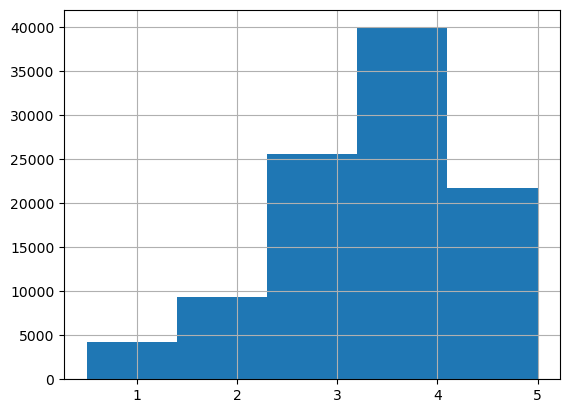

In [5]:
dataset['rating'].hist(bins=5)

In this dataset there are a lot of missing values, because not all the user/movie pairs have an associated rating. Indeed, each user rates only a few movies ! The goal of this notebook is to predict (some of) the missing user/movie ratings.

Print how many movies each of the 5 first users have rated, and print the percentage of available ratings in the whole dataset (i.e. the ratio between number of ratings and all the possible users/movies combinations):

In [6]:
for i in range(0,5):
    nb_ratings = len(dataset[dataset.userId == i])
    print(f'User {i} rated {nb_ratings} movies.')
    print(f'This is {round(nb_ratings / len(dataset) * 100, 3)}% of all ratings.')

User 0 rated 232 movies.
This is 0.23% of all ratings.
User 1 rated 29 movies.
This is 0.029% of all ratings.
User 2 rated 39 movies.
This is 0.039% of all ratings.
User 3 rated 216 movies.
This is 0.214% of all ratings.
User 4 rated 44 movies.
This is 0.044% of all ratings.


In [7]:
nb_ratings = len(dataset[dataset.userId < 5])
print(f'The first five users rated {nb_ratings} movies.')
print(f'This is {round(nb_ratings / len(dataset) * 100, 3)}% of all ratings.')

The first five users rated 560 movies.
This is 0.555% of all ratings.


In [8]:
print(f'This dataset is only {round(len(dataset)/(nb_movies*nb_users)*100, 1)}% of available ratings.')

This dataset is only 1.7% of available ratings.


There is only 1.7% of ratings that are available, which is normal as each hasn't rated all the movies. To see the dataset in a matrix form with all the missing ratings, use the `Dataframe.pivot()` function, with the `userId` as index, the `movieId` as columns, and the ratings for the `values` :

In [9]:
dataset

,userId,movieId,rating,timestamp
14430,90,1829,2.0,1112716724
43498,291,98,2.0,1265680159
73590,473,1321,3.5,1053021455
19181,123,97,3.5,1336584326
97254,604,3571,2.5,1277176881
...,...,...,...,...
52065,338,1182,2.0,1460182455
92269,596,828,5.0,941639399
18346,115,5721,4.5,1337199535
17425,110,3650,3.0,1516141691


In [10]:
#TOFILL
dataset.pivot(columns='movieId', index='userId', values='rating')

movieId,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
userId,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Print all the ratings of user 1. To do so, use the *movies.csv* file and your `movie_ids_map` dictionnary to find the movie title from the new movie indexes, and print the real movie title associated to each rating of user 1 :

In [11]:
#TOFILL
df_movies = pd.read_csv('../data/ml-latest-small/movies.csv')
df_movies['movieId'] = df_movies['movieId'].map(movie_ids_map)

In [12]:
df_merged = dataset.merge(df_movies, how='inner', on='movieId')
df_merged[df_merged.userId == 1][['rating', 'title']]

,rating,title
5078,4.0,"Departed, The (2006)"
7176,4.0,Whiplash (2014)
15419,4.5,Inglourious Basterds (2009)
19750,3.5,Collateral (2004)
21412,5.0,Inside Job (2010)
23856,3.0,Exit Through the Gift Shop (2010)
25197,3.5,"Dark Knight Rises, The (2012)"
35034,5.0,Step Brothers (2008)
36124,5.0,Mad Max: Fury Road (2015)
39036,4.0,Louis C.K.: Hilarious (2010)


In [13]:
# movies_idx = dataset[dataset['userId'] == 1].movieId.values
# original_key = [list(movie_ids_map.keys())[movie_idx] for movie_idx in movies_idx]

# movie_list = df_movies[df_movies.movieId.isin(original_key)].title.values

## Matrix Factorization with Keras

Keras is a python library made for easily designing complex models such as deep learning models, in this module we are going to use just a few features from it to implement our simple matrix factorization model, as it makes a good introduction to the library before the next module about deep learning where you will also be using Keras.

The following function `get_mf_model` implements the model described in equation (2) in Koren's paper (without the $+\lambda(\ldots)$ part for the moment). So it basically tries to find the $p_u \in \mathbb{R}^k$ and $q_i \in \mathbb{R}^k$ vectors that minimizes the squared loss between their dot product $p_u^Tq_i$, and the observed ratings $r_{ui}$, from random initialization of $p_u$ and $q_i$. In machine learning terms, $p_u$ and $q_i$ are called the *embeddings* of the user $u$ and of the movie $i$ respectively. Their size $k$ is an hyper-parameter of the model, which is called the *rank* of the factorization.

To do so, it uses the functional API from Keras (the other API proposed is the sequential one, but is not adapted for this model), you can read about it here : https://keras.io/guides/functional_api/ .

Keras, unlike Numpy, uses a different progamming paradigm. Numpy uses an *imperative* programming style (like python in general), meaning that when you execute `x.dot(y)`, the dot product is actually calculated. Keras however, uses a *declarative* (also called *symbolic*) programming style, meaning that when you write `Dot()([x, y])`, you tell Keras than when you will call the *fit* function of your model in the future, you will want to do a dot product between the future values that *x* and *y* will have. And this is what Keras is about, it allows you to build your own model as a sequence of operations, describing each input and output, and then later fit it and predict with it.

Let's not get in too many details, but retain that the `get_mf_model` function below is not actually executing the model, it creates it, and returns an object of the class `keras.models.Model` that has been instructed with your model operations, and this object can then be trained with the classic `fit` and `predict` functions. 

Read carefully the comments in the code of the function to understand the different steps in the model creation process:

In [14]:
from keras.models import Model
from keras.layers import Embedding, Input, Reshape
from keras.layers import Dot

def get_mf_model(nb_users, nb_movies, k):
    """
    Build a simple matrix factorization model from
    the number of user, the number of movies, and the size of the embeddings k.
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization
        
    """
    dim_embeddings = k
    
    #Inputs:
    #First we describe the input of the model, that is the training data that we will give it as X
    #In our case, the input are just the user index u and the movie index i.
    #So we declare two inputs of size one:
    u = Input(shape=(1,), dtype='int32', name = "u__user_id")
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    
    #Then let's declare our variable, the embeddings p and q.
    #First with the users, we declare that we have nb_users embeddings, each of size dim_embeddings.
    #An embedding object is indexed by calling it with the index parameter like a function,
    #so we add a `(u)` at the end to tell keras we want it to be indexed 
    #by the user ids we will pass at training time as inputs.
    p_u = Embedding(nb_users, dim_embeddings, name="p_u__user_embedding")(u)
    
    #Unfortunatly, when indexing an embeddings it keeps [1,k] matrix shape instead
    #of just a [k] vector, so we have to tell Keras that we just want a vector by
    #redefining its shape:
    p_u = Reshape((dim_embeddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Same thing for the movie embeddings:
    q_i = Embedding(nb_movies, dim_embeddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embeddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    #Then the dot product between the two indexed embeddings, 
    #we'll understand the axes = 1 part later.
    r_hat = Dot(axes = 1)([q_i, p_u])

    #We define our model by giving its input and outputs, in our case
    #the user and movie ids will be the inputs, and the output will be
    #the estimated rating r_hat, that is the dot product of the 
    #corresponding embeddings.
    model = Model(inputs=[u, i], outputs=r_hat)
    
    #Finally, we define the loss and metric to use, in our case the mean squared error,
    #along with the optimization method, we'll understand what is 'adam' later also.
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model



In [15]:
k = 30
mf_model = get_mf_model(nb_users, nb_movies, k)

Keras allows us to have a textual overview of the model we defined with the *summary()* function:

In [16]:
mf_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ i__movie_id         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u__user_id          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 1, 30)     │    291,720 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embedding │ (None, 1, 30)     │     18,300 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 30)        │          0 │ q_i__movie_embed… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embeddin… │ (None, 30)        │          0 │ p_u__user_embedd… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ q_i__movie_embed… │
│                     │                   │            │ p_u__user_embedd… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 310,020 (1.18 MB)

 Trainable params: 310,020 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Each of the keras objects we defined in our model is called a *layer*, and we find them in order in the first column. The *Param #* column gives the number of trainable parameters of the layer, in our case these are just the embeddings, and they should be equal to $nb\_users \times k$ and $nb\_movies \times k$. The *Connected to* column tells for each layer which layers are inputs for this layer (you can safely ignore the `[0][0]` for this module).

Finally the *Output Shape* column gives us the shape of the layer, each layer being a *tensor*. A tensor is the generalization of matrices to more than two dimensions. So a matrix is a 2D-tensor and a vector is a 1D-tensor, and each layer can be a matrix, a vector, or a higher-order tensor. The output shape we see is indeed the expected one at each layer, except there is this `None` in first dimension, why is that ?

To understand it, we have to get into how Keras is actually minimizing the mean squared loss of our model. In general, when in comes to minimizing error functions on big datasets, a generic method is to use Stocastic Gradient Descent (SGD), briefly described in page 4 of Koren's article. 

Read about gradient descent, SGD and its variant mini-batch SGD in Chapter 4 of *Hands on ML ...* (pages 111-120):
https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

This is what Keras does when it fits the model, it initializes the $q_i$ and $p_u$ embedding vectors randomly, and then perform mini-batch SGD to find the minimum mean squared error on the training set. Since mini-batching means considering multiple training samples at the same time, Keras keeps the first dimension of each layer to stack the samples of each batch, this is why `None` is written, the actual batch_size being set at training time when calling the `fit` function. This is also why we had to set `axes=1` when calling the `Dot` layer in the `get_mf_model` function, because the first dimension (axe 0) of each layer is kept for the batches. And about the `optimizer='adam'`, it is just a variation of mini-batch SGD that is faster, we'll get into more details about SGD variations in the optional parts of this notebook.

Let's finally train our matrix factorization model on our movieLens data. The `epochs` parameter controls the number of iterations of the SGD algorithm, that is the number of times it is going to pass on each training rating and update the embeddings accordingly. Let's keep it at 20 for the moment:

In [17]:
history = mf_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.3715 - mse: 13.3715
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.0625 - mse: 12.0625
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4040 - mse: 5.4040
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6101 - mse: 2.6101
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7715 - mse: 1.7715
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3382 - mse: 1.3382
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0991 - mse: 1.0991
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9447 - mse: 0.9447
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8387 - mse: 0.8387
Epoch 10/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7689 - mse: 0.7689
Epoch 11/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7038 - mse: 0.7038
Epoch 12/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6663 - mse: 0.6663
Epoch 13/20
178/178 ━━━━━━━━━━━━

And we can now try to predict the test ratings, and report our root mean squared error like in other regression problems:

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = mf_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
 Test RMSE : 1.106894065293042 


You should get about 1.1/1.2 RMSE, we can probably do better !

## Train the same model on your GPU and on your CPU, and compare the training time

Keras uses the `tensorflow` python library for the computation part, if you have installed your GPU drivers and the GPU version of keras, then it will run on your GPU by default. We can force tensorflow to use the cpu instead:

In [19]:
import tensorflow as tf

with tf.device('/cpu:0'):
    mf_model = get_mf_model(nb_users, nb_movies, k)
    history = mf_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.3616 - mse: 13.3616
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.2580 - mse: 12.2580
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3390 - mse: 5.3390
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6095 - mse: 2.6095
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7405 - mse: 1.7405
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3370 - mse: 1.3370
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1024 - mse: 1.1024
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9426 - mse: 0.9426
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8333 - mse: 0.8333
Epoch 10/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7639 - mse: 0.7639
Epoch 11/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7128 - mse: 0.7128
Epoch 12/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - mse: 0.6683
Epoch 13/20
178/178 ━━━━━━━━━━━━

Our matrix farctorization model is a really simple model, with not enough operations to parallelize on the GPU, this is why the training time is quite similar for this model. However with deep networks models the training time can be up to 10x times faster on a GPU.

## Adding user and movie bias

Let's enhance our matrix factorization model and add the user and movie biases to the rating estimation function as in equation (4) of Koren's paper ; except we will for the moment forget about the global bias $\mu$ as it is not so intuitive to implement in Keras. Fill the function below to do so:

In [20]:
from keras.layers import Add

def get_mf_bias_model(nb_users, nb_movies, k):
    """
    Build a smatrix factorization model with user and movie biases
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
        
    """

    dim_embeddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embeddings, name="p_u__user_embedding")(u)
    p_u = Reshape((dim_embeddings,), name="p_u__user_embedding_reshaped")(p_u)
    b_u = Embedding(nb_users, 1, name='b_u__user_embedding')(u)
    b_u = Reshape((1,), name='b_u__user_embedding_reshaped')(b_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embeddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embeddings,), name="q_i__movie_embedding_reshaped")(q_i)
    b_i = Embedding(nb_movies, 1, name='b_i__movie_embedding')(i)
    b_i = Reshape((1,), name='b_i__movie_embedding_reshaped')(b_i)
    
    # Dot product
    d = Dot(axes = 1)([p_u, q_i])
    r_hat = Add()([d, b_u, b_i])

    #We define our model by giving its input and outputs, in our case
    #the user and movie ids will be the inputs, and the output will be
    #the estimated rating r_hat, that is the dot product of the 
    #corresponding embeddings plus the user and movie biases.
    model = Model(inputs=[u, i], outputs=r_hat)
    
    #Finally, we define the loss and metric to use, in our case the mean squared error,
    #along with the optimization method, we'll understand what is 'adam' later also.
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model


In [21]:
mf_bias_model = get_mf_bias_model(nb_users, nb_movies, k)

In [22]:
mf_bias_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ u__user_id          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ i__movie_id         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embedding │ (None, 1, 30)     │     18,300 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 1, 30)     │    291,720 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embeddin… │ (None, 30)        │          0 │ p_u__user_embedd… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 30)        │          0 │ q_i__movie_embed… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_embedding │ (None, 1, 1)      │        610 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__movie_embeddi… │ (None, 1, 1)      │      9,724 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 1)         │          0 │ p_u__user_embedd… │
│                     │                   │            │ q_i__movie_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_embeddin… │ (None, 1)         │          0 │ b_u__user_embedd… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__movie_embeddi… │ (None, 1)         │          0 │ b_i__movie_embed… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1)         │          0 │ dot_2[0][0],      │
│                     │                   │            │ b_u__user_embedd… │
│                     │                   │            │ b_i__movie_embed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 320,354 (1.22 MB)

 Trainable params: 320,354 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = mf_bias_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12.8163 - mse: 12.8163
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.0174 - mse: 10.0174
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2782 - mse: 4.2782
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0222 - mse: 2.0222
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3643 - mse: 1.3643
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0614 - mse: 1.0614
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9022 - mse: 0.9022
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7918 - mse: 0.7918
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7317 - mse: 0.7317
Epoch 10/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6720 - mse: 0.6720
Epoch 11/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6243 - mse: 0.6243
Epoch 12/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6014 - mse: 0.6014
Epoch 13/20
178/178 ━

In [24]:
y_pred = mf_bias_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 Test RMSE : 0.9885945860436196 


You should get a lower RMSE, about 1.0/1.1

## Adding L2 regularization

For the moment we have omitted the regularization of the embeddings and bias parameters, as described in equation (5) of Koren's paper. We are now going to add them to the model, have a look at https://keras.io/layers/embeddings/ and https://keras.io/regularizers/ to see how to do this with keras. Fill the function below to implement it:

In [48]:
from keras import regularizers

def get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_):
    """
    Build a smatrix factorization model with user and movie biases, and L2 regularization
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
            and L2 regularization
        
    """

    #TOFILL
    dim_embeddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embeddings,  
                    embeddings_regularizer=regularizers.l2(lambda_), 
                    name="p_u__user_embedding")(u)
    p_u = Reshape((dim_embeddings,), name="p_u__user_embedding_reshaped")(p_u)
    b_u = Embedding(nb_users, 1,  
                    embeddings_regularizer=regularizers.l2(lambda_), 
                    name='b_u__user_embedding')(u)
    b_u = Reshape((1,), name='b_u__user_embedding_reshaped')(b_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embeddings,   
                    embeddings_regularizer=regularizers.l2(lambda_), 
                    name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embeddings,), name="q_i__movie_embedding_reshaped")(q_i)
    b_i = Embedding(nb_movies, 1,   
                    embeddings_regularizer=regularizers.l2(lambda_), 
                    name='b_i__movie_embedding')(i)
    b_i = Reshape((1,), name='b_i__movie_embedding_reshaped')(b_i)
    
    # Dot product
    d = Dot(axes = 1)([p_u, q_i])
    r_hat = Add()([d, b_u, b_i])

    #We define our model by giving its input and outputs, in our case
    #the user and movie ids will be the inputs, and the output will be
    #the estimated rating r_hat, that is the dot product of the 
    #corresponding embeddings plus the user and movie biases.
    model = Model(inputs=[u, i], outputs=r_hat)
    
    #Finally, we define the loss and metric to use, in our case the mean squared error,
    #along with the optimization method, we'll understand what is 'adam' later also.
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model




In [49]:
lambda_ = 0.00001
mf_bias_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

In [50]:
mf_bias_reg_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ u__user_id          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ i__movie_id         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embedding │ (None, 1, 30)     │     18,300 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 1, 30)     │    291,720 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_u__user_embeddin… │ (None, 30)        │          0 │ p_u__user_embedd… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_i__movie_embeddi… │ (None, 30)        │          0 │ q_i__movie_embed… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_embedding │ (None, 1, 1)      │        610 │ u__user_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__movie_embeddi… │ (None, 1, 1)      │      9,724 │ i__movie_id[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_14 (Dot)        │ (None, 1)         │          0 │ p_u__user_embedd… │
│                     │                   │            │ q_i__movie_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_u__user_embeddin… │ (None, 1)         │          0 │ b_u__user_embedd… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b_i__movie_embeddi… │ (None, 1)         │          0 │ b_i__movie_embed… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 1)         │          0 │ dot_14[0][0],     │
│                     │                   │            │ b_u__user_embedd… │
│                     │                   │            │ b_i__movie_embed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 320,354 (1.22 MB)

 Trainable params: 320,354 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = mf_bias_reg_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 13.0276 - mse: 13.0258
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.9800 - mse: 10.9760
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4479 - mse: 5.4239
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3732 - mse: 2.3227
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6148 - mse: 1.5472
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2932 - mse: 1.2131
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0755 - mse: 0.9856
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9753 - mse: 0.8775
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9016 - mse: 0.7972
Epoch 10/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8383 - mse: 0.7284
Epoch 11/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8108 - mse: 0.6964
Epoch 12/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7779 - mse: 0.6597
Epoch 13/20
178/178 ━━━━━━━━━━━━

In [52]:
y_pred = mf_bias_reg_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 Test RMSE : 1.0297013598886624 


You might get a slightly worse (higher) RMSE, because adding regularization makes the optimization process more complex, and it probably requires more than 20 epochs to properly converge. But in the end its gonna yield better results with more iterations, so let's change this.

## Early Stopping

Instead of setting manually the maximum number of epochs, we prefer to use *early stopping*. When training with early stopping, keras keeps a given validation set though the parameter `validation_split`, on which it is going to monitor a performance measure you give it (here the `mse`) at every epoch, and continue optimization while the mse on the validation set keeps going down, and stops it when it goes back up. This mechanism is an easy way to avoid over-fitting, you can read more about it there : https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In general when using early stopping we setup a high number of maximum epochs, that is never reach because the optimization is stopped by early stopping first :

In [ ]:
from keras.callbacks import EarlyStopping

mf_bias_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

early_stopping = EarlyStopping(monitor='val_mse', patience=5, restore_best_weights=True)

history = mf_bias_reg_model.fit(X_train, y_train, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 13.0324 - mse: 13.0306 - val_loss: 11.9718 - val_mse: 11.9701
Epoch 2/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11.4039 - mse: 11.4009 - val_loss: 8.1903 - val_mse: 8.1783
Epoch 3/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6577 - mse: 6.6394 - val_loss: 3.5440 - val_mse: 3.5055
Epoch 4/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8017 - mse: 2.7575 - val_loss: 2.2875 - val_mse: 2.2288
Epoch 5/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7838 - mse: 1.7215 - val_loss: 1.8388 - val_mse: 1.7668
Epoch 6/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3745 - mse: 1.2997 - val_loss: 1.6150 - val_mse: 1.5326
Epoch 7/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1616 - mse: 1.0771 - val_loss: 1.4853 - val_mse: 1.3945
Epoch 8/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0321 - mse: 0.9394 - val_loss: 1.4043 - val_mse: 1.3066
Epoch 9/500
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

In [54]:
y_pred = mf_bias_reg_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 Test RMSE : 1.0412470637031324 


As you can see the training stops before 500 epochs, when the validation MSE stops decreasing during 5 consecutive epochs (the patience value = 5). 

## Grid search embedding size and regularization factor with early stopping

So for the moment we didn't grid search our model hyper-parameters, such as `k` and `lambda_`. There exists some scikit-learn wrappers for keras models in order to use scikit grid search functions, unfortunately they only work with single input keras models, which is not our case as we have two inputs: the user and the movie indexes.

So let's implement your own grid search function for the two parameters `k` and `lambda_`. With big enough datasets, it is not necessary to do a cross-validation for each hyper-parameter combination, and we can simply split the training set into a sub-training set and a validation set to test our hyper-parameters. It does work because the validation set is big enough to see enough data variations, and with very big datasets, it is anyway not possible anymore to do a full cross-validation as it takes too much time to train. 

Fill in the `grid_search` function below and use early stopping with a validation split (just like above), and retrieve the validation RMSE (you can get the MSE from the `history` variable that is returned by the `fit` method (and then take the `sqrt` of that)) for all the hyper-parameter combinations from the `param_grid` dictionary of hyper-parameter values. Call the `get_model_function` parameter (yes, you can pass functions as parameters!) to generate each model, and return the hyper-parameters that give the lowest RMSE on the 10% validation set, the RMSE value, and the best corresponding trained model.

In [56]:
import itertools

def grid_search(train, param_grid, get_model_function, nb_users, nb_movies, validation_size = 0.1):
    """
    Performs a grid search over the 
    
    Input:
        data : DataFrame : The training set to be split between training and validation sets
        param_grid : dict : Dictionary containing the values of the hyper-parameters to grid-search
        get_model_function : function : A function that returns the keras model to grid-search
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        validation_size : float : Proportion of the validation set
        
    Output:
        best_params : dict : A dictionary of the best hyper-parameters values
        best_score : float : The validation RMSE corresponding to the best
        best_model : keras.Model : The model trained with the best hyper-parameters
        
    """
    train_train, train_val = train_test_split(train, test_size=validation_size)
    X_train = [train_train["userId"].to_numpy(), train_train["movieId"].to_numpy()]
    y_train = train_train["rating"].to_numpy()

    X_val = [train_val["userId"].to_numpy(), train_val["movieId"].to_numpy()]
    y_val = train_val["rating"].to_numpy()

    keys, values = zip(*param_grid.items())
    permutation_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    results = {}
    best_score = np.inf
    for permutation in permutation_dicts:
        mf_bias_reg_model = get_model_function(nb_users, nb_movies, **permutation)
        early_stopping = EarlyStopping(monitor='val_mse', patience=5, restore_best_weights=True, verbose=0)
        history = mf_bias_reg_model.fit(X_train, y_train, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping], verbose=0)

        y_val_pred = mf_bias_reg_model.predict(X_val)
        results[tuple(sorted(permutation.items()))] = sqrt(mean_squared_error(y_val, y_val_pred))

        if sqrt(mean_squared_error(y_val, y_val_pred)) < best_score:
            best_score = sqrt(mean_squared_error(y_val, y_val_pred))
            best_params = permutation
            best_model = mf_bias_reg_model 

    return best_params, best_score, best_model, results

In [57]:
lambdas_ = [0.0002, 0.00005, 0.00002]
ks = [15, 30]

param_grid = { 'k' : ks, 'lambda_' : lambdas_ }

best_params, best_score, best_model, results = grid_search(train, param_grid, get_mf_bias_l2_reg_model,
                                                           nb_users, nb_movies, validation_size = 0.1)


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [58]:
results

{(('k', 15), ('lambda_', 0.0002)): 0.95503275090506,
 (('k', 15), ('lambda_', 5e-05)): 0.9990512910687758,
 (('k', 15), ('lambda_', 2e-05)): 1.0388329594271764,
 (('k', 30), ('lambda_', 0.0002)): 0.9556544443287759,
 (('k', 30), ('lambda_', 5e-05)): 0.9786648159565682,
 (('k', 30), ('lambda_', 2e-05)): 1.0710922917606442}

In [59]:
print('Best hyper-parameters : ' + str(best_params))
print('Best validation RMSE : ' + str(best_score))

Best hyper-parameters : {'k': 15, 'lambda_': 0.0002}
Best validation RMSE : 0.95503275090506


In [60]:
y_pred = best_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print("Best model test RMSE : %s " % test_rmse)

  1/316 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Best model test RMSE : 0.9585496925841988 


## Retrain on all the dataset with the best hyper-parameters

Actually other hyper-parameters such as the ones of SGD should also be grid-searched, like the number of epochs or the batch size. But that would be a bit long for this course. 

Now we want to do the best prediction possible, so retrain below your model on the whole dataset, including the test set, with the best values obtained from your grid search to make new predictions with our optimal parameters :

In [61]:
X = [dataset["userId"].to_numpy(), dataset["movieId"].to_numpy()]
y = dataset["rating"].to_numpy()

#TOFILL
best_model=get_mf_bias_l2_reg_model(nb_users, nb_movies, k =15, lambda_ =0.0002)

early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)

best_model.fit(X, y, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')
  warnings.warn(


178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 12.9972 - mse: 12.9852 - val_loss: 11.9008 - val_mse: 11.8885
Epoch 2/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.3121 - mse: 11.2808 - val_loss: 8.7950 - val_mse: 8.6415
Epoch 3/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6775 - mse: 7.4467 - val_loss: 5.0476 - val_mse: 4.5612
Epoch 4/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4465 - mse: 3.8804 - val_loss: 3.6494 - val_mse: 2.8792
Epoch 5/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3289 - mse: 2.5096 - val_loss: 3.2225 - val_mse: 2.2815
Epoch 6/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9376 - mse: 1.9665 - val_loss: 3.0289 - val_mse: 1.9797
Epoch 7/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7477 - mse: 1.6782 - val_loss: 2.9194 - val_mse: 1.7947
Epoch 8/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6444 - mse: 1.5054 - val_loss: 2.8474 - val_mse: 1.6709
Epoch 9/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

In [62]:
y_pred = best_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print("Best model test RMSE : %s " % test_rmse)

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best model test RMSE : 0.950803305611022 


## Recommend the top-5 movies for the 10 first users

With your retrained best model with optimal hyper parameters, compute the predictions for all the ratings that are not in the `dataset` for the 10 first users (indexes from 0 to 9). That means all the movies $i$ that these users $u \in 0,\ldots,9$ haven't rated, thus all the $u,i$ combinations that are not in the `dataset` dataframe rows.

Order these predicted ratings for these users by decreasing order, and print out the 5 first ones, i.e. the ones that have the highest predicted ratings. Use the *movies.csv* file to print the real titles.

In [ ]:
def get_top5_for_user(model, user_id, dataset):
    """
    Returns a list of the 5 movies that have the highest ratings among the unrated movies
    of user `user_id`, along with a list of their predicted ratings.
    
    Input :
        model : keras.models.Model : A trained matrix factorization model
        user_id : int : The user id to use
        dataset : DataFrame : The whole dataset, useful to find the movies 
            the user `user_id` has already rated
    
    Output :
        five_best_movie_ids : list : The five movie ids among unrated movies by user `user_id` 
            that have the highest predicted ratings, in order
        five_best_ratings : list : The corresponding five ratings
    """
    
    #TOFILL
    movies_watched = dataset[dataset.userId == user_id]['movieId']
    movies_unwatched = (dataset['movieId'][~dataset['movieId'].isin(movies_watched)]
                                                            .sort_values()
                                                            .unique())

    user_array = np.ones(len(movies_unwatched), dtype='int') * user_id

    ratings = model.predict([user_array,movies_unwatched])

    five_best_ratings = ratings[np.argsort(ratings, axis=0)[-5:]]
    five_best_movie_ids = movies_unwatched[np.argsort(ratings, axis=0)[-5:]]


    return five_best_movie_ids, five_best_ratings

In [117]:
def get_user_predictions(model, user_id, dataset):
    """
    Returns a list of the 5 movies that have the highest ratings among the unrated movies
    of user `user_id`, along with a list of their predicted ratings.
    
    Input :
        model : keras.models.Model : A trained matrix factorization model
        user_id : int : The user id to use
        dataset : DataFrame : The whole dataset, useful to find the movies 
            the user `user_id` has already rated
    
    Output :
        five_best_movie_ids : list : The five movie ids among unrated movies by user `user_id` 
            that have the highest predicted ratings, in order
        five_best_ratings : list : The corresponding five ratings
    """
    
    #TOFILL
    movies_watched = dataset[dataset.userId == user_id]['movieId']
    movies_unwatched = (dataset['movieId'][~dataset['movieId'].isin(movies_watched)]
                                                            .sort_values()
                                                            .unique())

    user_array = np.ones(len(movies_unwatched), dtype='int') * user_id

    ratings = model.predict([user_array,movies_unwatched])

    
    return movies_unwatched, ratings

In [159]:
#TOFILL
df_predictions = pd.DataFrame(columns=['userId', 'movieName', 'rating'])
user_ids = np.arange(0,5)

for user_id in user_ids:
    df_user = pd.DataFrame(columns=['userId', 'movieName', 'rating'])
    movies_unwatched, ratings = get_user_predictions(best_model, user_id, dataset)

    five_best_ratings = ratings[np.argsort(ratings, axis=0)[-5:]]
    five_best_movie_ids = movies_unwatched[np.argsort(ratings, axis=0)[-5:]]

    df_user['userId'] = np.ones(5, dtype='int') * user_id
    df_user['movieName'] = df_movies[df_movies['movieId'].isin(five_best_movie_ids.flatten().tolist())]['title'].values
    df_user['rating'] = five_best_ratings.flatten()
    df_user = df_user.sort_values('rating', ascending=False)

    # display(df_user)

    df_predictions = pd.concat((df_predictions, df_user))

297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
  1/303 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step

/var/folders/cw/t92_wwv10n16x5plcfhdtwxh0000gn/T/ipykernel_55321/908599944.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_predictions = pd.concat((df_predictions, df_user))


303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
df_predictions

,userId,movieName,rating
4,0,"Lord of the Rings: The Return of the King, The...",5.143856
3,0,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.949150
2,0,One Flew Over the Cuckoo's Nest (1975),4.942685
1,0,"Godfather, The (1972)",4.900630
0,0,"Shawshank Redemption, The (1994)",4.886535
4,1,Fight Club (1999),3.792441
3,1,"Matrix, The (1999)",3.732573
2,1,Forrest Gump (1994),3.700180
1,1,Pulp Fiction (1994),3.689706
0,1,"Usual Suspects, The (1995)",3.673178


## Visualize the embeddings

Let's now have a look at what is going on in the embedding space of the movies that we learnt. Our brain cannot picture anything beyond 3 dimensions, and we learnt high dimensional embeddings (k=15 or 30), so we are going to project the movies embeddings on a 2D plane, first with PCA, and then with another algorithm made for visualizing high dimensional spaces called t-sne.

### PCA

You have already studied PCA, it is a useful technique for dimensionality reduction, but also simply for visualization. Don't forget to scale your embeddings first. To access the embeddings values of your keras model, have a look at the *get_weights()* function.

Compute a PCA on all your movies embeddings, get the 2 first principal components, and do a scatter plot of all the movies on a 2D plane, where each movie is a point defined by the two values of the two first principal components of the PCA from its embedding. Add the titles of the movies to each point of the plot (use plotly to do so it will be clearer), and try to see if you can interpret the axes of the PCA through to different movie genres, like in Figure 3 from the article *Matrix Factorization Techniques for Recommender Systems*.

In [170]:
movie_weights = best_model.get_weights()[1]
movie_weights

array([[-3.3893156e-01,  1.6363898e-01, -3.5332575e-01, ...,
        -1.8347830e-02,  3.6746100e-01, -2.1758254e-01],
       [-2.7587402e-01,  1.7271622e-01, -1.8477072e-01, ...,
         1.5258144e-01,  1.1896332e-01, -8.6265914e-02],
       [-1.7031994e-01,  4.6088446e-02, -1.5320289e-01, ...,
         1.1552615e-01,  1.0730253e-02,  9.4964929e-02],
       ...,
       [-1.4103764e-02,  1.0808369e-02, -7.4576745e-03, ...,
        -7.1957693e-03,  6.7345994e-03, -5.0829621e-03],
       [-9.0165660e-03,  5.1019210e-03, -1.5610635e-03, ...,
        -1.4082085e-03,  1.0060595e-03, -2.2916609e-04],
       [-3.2732256e-02,  2.6767472e-02, -1.8604703e-02, ...,
        -3.0209724e-02,  5.9269471e-03, -1.5178504e-02]], dtype=float32)

In [179]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

#TOFILL
movie_weights = StandardScaler().fit_transform(movie_weights)

pca = PCA(n_components=2)
pca_out = pca.fit_transform(movie_weights)

In [180]:
df_pca = pd.DataFrame(pca_out, columns=['pc1', 'pc2'])
df_pca['movieName'] = df_movies['title']
df_pca

,pc1,pc2,movieName
0,-14.324350,5.428971,Toy Story (1995)
1,-7.198967,6.380879,Jumanji (1995)
2,-5.042303,3.599745,Grumpier Old Men (1995)
3,-0.301312,1.251098,Waiting to Exhale (1995)
4,-4.273000,6.541173,Father of the Bride Part II (1995)
...,...,...,...
9719,0.804509,0.074200,Spiral (2018)
9720,0.565032,0.031315,Mission: Impossible - Fallout (2018)
9721,0.746056,0.083879,SuperFly (2018)
9722,1.034002,0.142522,Iron Soldier (2010)


In [215]:
fig = px.scatter(df_pca, x="pc1", y="pc2", hover_data=['movieName'], width=600, height=600)
fig.show()

## t-sne

Let's do the same with t-sne, an algorithm specialized for visualizing high dimensional spaces, you can read more about it there : https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [203]:
from sklearn.manifold import TSNE

#TOFILL:
tsne_out = TSNE(n_components=2, n_jobs=-1).fit_transform(movie_weights)

In [213]:
df_tsne = pd.DataFrame(tsne_out, columns=['TSNE1', 'TSNE2'])
df_tsne['movieName'] = df_movies['title']
df_tsne

,TSNE1,TSNE2,movieName
0,-66.446938,28.320713,Toy Story (1995)
1,-61.021183,30.916378,Jumanji (1995)
2,-56.198715,29.996241,Grumpier Old Men (1995)
3,-8.368388,4.457096,Waiting to Exhale (1995)
4,-55.995651,32.317894,Father of the Bride Part II (1995)
...,...,...,...
9719,13.650812,-15.645811,Spiral (2018)
9720,5.414999,-13.121619,Mission: Impossible - Fallout (2018)
9721,13.433578,-15.245329,SuperFly (2018)
9722,30.886576,-19.204550,Iron Soldier (2010)


In [214]:
fig = px.scatter(df_tsne, x="TSNE1", y="TSNE2", hover_data=['movieName'], width=600, height=600)
fig.show()

T-sne in general tends to preserve local similarities better than PCA. In any case, it's always interesting to try both for visualizing high dimensional data.

In [235]:
str(vec[0].tolist()).replace(", ", "\t")


'[-0.3389315605163574\t0.16363897919654846\t-0.353325754404068\t-0.683238685131073\t0.3293694853782654\t0.0801011472940445\t0.43952736258506775\t0.04160870239138603\t0.4769286513328552\t-0.4407675862312317\t0.12521877884864807\t-0.15635553002357483\t-0.018347829580307007\t0.3674609959125519\t-0.21758253872394562]'

In [220]:
import io

out_v = io.open('vecs_films.tsv', 'w', encoding='utf-8')
vec = best_model.get_weights()[1]
out_v.write(r'\t'.join([str(x) for x in vec]) + "\n")
out_v.close()

Optionally, you can export your embedding and upload them on https://projector.tensorflow.org/ to visualize the embeddings in 3D. You can also use the movies genres from the *movies.csv* file to make one plot for each movie genre and try to see if some parts of the embedding space are representative of a movie genre.

# GOING FURTHER

## Recommend movies to yourself

Implement a function that ask you to rate 20 movies, then add your own ratings to the dataset, retrain the model, and compute your own top-5 predictions.

In [ ]:
import random

def rate_my_movies(my_user_id, dataset, nb_movies, idx_movies, nb_to_rate):
    """
    Returns a dataframe in the same format as the dataset dataframe, with
    ratings entered by the user for `nb_to_rate` random movies
    
    Input :
        my_user_id : int : The user_id of the new ratings
        dataset : DataFrame : The whole dataset of movies
        nb_to_rate : int : Number of movies to rate
    
    Output : 
        my_ratings : DataFrame : A dataframe with the same column as `dataset` containing
            the new ratings entered by the user
        df_user : DataFrame : A dataframe containing the userId, movieIds, movieName, and rating
    """
    #TOFILL
    # subset = dataset.sample(nb_to_rate)
    ratings=[]
    movieIds = []
    movieTitles = []

    i = 0
    # j = 0
    df_user = pd.DataFrame(columns = ['userId', 'movieIds', 'movieName', 'rating'])
    while i < nb_to_rate:
        idx = random.randint(0, nb_movies)
        # idx = idx_movies[j]
        # j = j + 1
        try:
            rating_val = float(input(f'Rating for {dataset.iloc[idx]['title']}:'))
            print(rating_val)
            if (rating_val <= 5) and (rating_val >= 0):
                ratings.append(rating_val)
                movieIds.append(dataset.iloc[idx]['movieId'])
                movieTitles.append(dataset.iloc[idx]['title'])
                print(i)
                i += 1
            else:
                continue
        except ValueError:
            print("Please enter a rating between 0 and 5.")
            continue
        else:
            continue
    
    df_user['userId'] = np.ones(nb_to_rate, dtype='int') * my_user_id
    df_user['movieId'] = movieIds
    df_user['movieName'] = movieTitles
    df_user['rating'] = ratings

    return ratings, df_user

movie_idx = (dataset.groupby('movieId')['rating']
                    .mean()
                    .sort_values(ascending=False)
                    .reset_index()['movieId']
                    .values)

my_user_id = len(user_ids_map)

# my_ratings, df_ratings = rate_my_movies(my_user_id, df_movies, nb_movies, movie_idx, 20)
df_ratings = pd.read_csv('../data/my_ratings.csv')

Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
3.7
0
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rating between 0 and 5.
Please enter a rati

In [ ]:
# df_ratings.to_csv('../data/my_ratings.csv')

In [332]:
import time
df_user = df_ratings.copy()
df_user = df_user.drop('movieName', axis=1)
df_user['timestamp'] = round(time.time())

In [307]:
dataset_user = pd.concat((dataset, df_user))

In [ ]:
X_with_me = [dataset_user["userId"].to_numpy(), dataset_user["movieId"].to_numpy()]
y_with_me = dataset_user["rating"].to_numpy()

In [321]:
best_model=get_mf_bias_l2_reg_model(nb_users + 1, nb_movies, k = best_params['k'], lambda_ = best_params['lambda_'])

early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)

best_model.fit(X_with_me, y_with_me, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500


/Users/fluids/miniconda3/envs/tensor/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: ['u__user_id', 'i__movie_id']. Received: the structure of inputs=('*', '*')



178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 13.0056 - mse: 12.9934 - val_loss: 11.8444 - val_mse: 11.8305
Epoch 2/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.2452 - mse: 11.2100 - val_loss: 8.6074 - val_mse: 8.4422
Epoch 3/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5476 - mse: 7.3065 - val_loss: 5.0368 - val_mse: 4.5485
Epoch 4/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.4169 - mse: 3.8516 - val_loss: 3.6723 - val_mse: 2.9066
Epoch 5/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.2989 - mse: 2.4852 - val_loss: 3.2449 - val_mse: 2.3097
Epoch 6/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9560 - mse: 1.9896 - val_loss: 3.0497 - val_mse: 2.0056
Epoch 7/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7500 - mse: 1.6854 - val_loss: 2.9396 - val_mse: 1.8194
Epoch 8/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6467 - mse: 1.5117 - val_loss: 2.8684 - val_mse: 1.6957
Epoch 9/500
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

In [324]:
five_best_movie_ids, five_best_ratings =  get_top5_for_user(best_model, my_user_id, dataset_user)

In [331]:
df_my_pred = pd.DataFrame(columns=['userId', 'movieName', 'rating'])
movies_unwatched, ratings = get_user_predictions(best_model, my_user_id, dataset_user)

df_my_pred['movieName'] = df_movies[df_movies['movieId'].isin(movies_unwatched.flatten().tolist())]['title'].values
df_my_pred['rating'] = ratings.flatten()
df_my_pred['userId'] = my_user_id
df_my_pred = df_my_pred.sort_values('rating', ascending=False)

df_my_pred.head(10)


304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


,userId,movieName,rating
277,610,"Shawshank Redemption, The (1994)",1.445746
314,610,Forrest Gump (1994),1.290720
224,610,Star Wars: Episode IV - A New Hope (1977),1.184236
509,610,"Silence of the Lambs, The (1991)",1.156008
46,610,"Usual Suspects, The (1995)",1.145571
31,610,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),1.137612
257,610,Pulp Fiction (1994),1.136750
398,610,"Fugitive, The (1993)",1.136365
506,610,Terminator 2: Judgment Day (1991),1.134214
1932,610,"Matrix, The (1999)",1.118404


## Reuse the movie embeddings to predict the movies genre with multi-label classification

Beyond the goal of predicting missing rating, the matrix factorization techniques also produces vectorial representation of movies and users: their embeddings, what we just visualized for the movies. With a big enough dataset, these embeddings actually are good abstract representations of the movies and of the users, and can be reused as features for other tasks, such as classification.

In the *movies.csv*, there is a column that gives the genres of each movie. Let's try to predict the genres of the movies from the embeddings we learnt. As you can see, each movie can have more than one genre, so in classification terms, more than one class. We can achieve that with *multilabel classification*. You can read more about it there: https://scikit-learn.org/stable/modules/multiclass.html

Load the movies genre, encode them as binary classes and use the classes imported below to train a multilabel classifier that uses the movie embeddings as features, and the movie genres as classes. Use the *OneVsRestClassifier* with a simple *LinearSVC* without any hyper-parameter tuning. Finally print the test accuracy, F1, precision and recall for each class, as well as the number of time each class appears in the dataset.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#TOFILL


On rare classes, you should get a very high accuracy, with a very low F1. Indeed these classes are really imbalanced : there are a few positives, hence the classifier is largely biased toward the negatives, and rarely predict a positive for these classes. This is why accuracy is generally a bad measure with imbalanced dataset : the high number of true negatives makes the accuracy number high, while our model is actually barely capable of predicting true positives.

Let's compare our classifier performance with a *DummyClassifier*, the dummy classifier takes the ratio $r = \frac{nb\_positives}{nb\_positives + nb\_negatives}$ as the probability to predict a positive, and then do it randomly.

In [ ]:
from sklearn.dummy import DummyClassifier

#TOFILL



As you can see, simply respecting the class balance, even at random, produces better F1 on most classes. One way to compensate for class imbalance is to tell the classifier to weight more the true samples at training time, accordingly with the ratio $r$ between true and false samples. With scikit-learn SVM implementation, you can use the argument *class_weight* for setting the weight of the positive and negative samples at training time. See : https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

But if you just want to set the class weights accordingly with the ratio between positives and negatives, you can just set *class_weight = ‘balanced’*. Test it with the LinearSVC classifier:

In [ ]:
#TOFILL



F1 is now much better than with the dummy classifier, however is is still not very convincing. This is quite normal given the size of the dataset we are using, which is pretty small to get really meaningful embeddings. But with bigger datasets, reusing embeddings as features for auxiliary tasks such as classification is actually a very effective way of doing so when there is no other informations about the items we try to classify. Here the items are the movies, the dataset doesn't provide more information about them, but one could imagine fetching from internet textual descriptions of the movies and use them as features alongside the embeddings to improve the classification results.

## Try out the different SGD algorithms

In all the notebook we used the 'adam' `optimizer` to train our model, which is a variation of SGD. Keras proposes different variations of SGD: https://keras.io/optimizers/ . This article gif images gives an intuitive view of their different behavior : https://medium.com/@ramrajchandradevan/the-evolution-of-gradient-descend-optimization-algorithm-4106a6702d39

Try a few ones with our model and see how the training and testing loss evolves.

In [ ]:
#TOFILL

## Add the global bias $\mu$  parameter to the model

Remember we didn't added the global bias $\mu$ to our model yet (Equations (4-5) from Koren's paper). Use your best google skills to find a way to add an embedding layer that does that.

Hint : Use a constant `Input` layer.

In [ ]:
from keras import backend as K
#TOFILL


## Implement your own Stochastic Gradient Descent for Matrix Factorization with numpy instead of Keras (very optional)

Now you know everything to implement your own matrix factorization SGD model, all with numpy arrays. Start without the biases again, and without mini-batches. The gradient update equations are described in page 4 of Koren's paper. Let's initialize your $p$ and $q$ embeddings with a gaussian sampling. Print the RMSE at the beginning of each epoch, and finally compute the RMSE of your model on the test set.

In [ ]:
from numpy.random import normal

P = normal(size = (nb_users,k))
Q = normal(size = (nb_movies,k))

gamma = 0.1
lambda_ = 0.00001
epochs = 10

for e in range(epochs):
    for j in range(train.shape[0]):
        u = train['userId'].iloc[j]
        i = train['movieId'].iloc[j]
        r_ui = train['rating'].iloc[j]
        
        #TOFILL
